In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import itertools
import matplotlib.ticker as ticker
from matplotlib import font_manager, rc
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import aic, bic
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from itertools import product
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import boxcox
from sklearn.preprocessing import PowerTransformer

In [3]:
cow_df = pd.read_csv("2013~2023 OASIS 한우 도매가격.csv")

In [4]:
# '경락일자'에서 년도와 월을 분리
cow_df['년도'] = '20' + cow_df['경락일자'].str.split('-').str[0]

# 월 이름을 숫자로 매핑
month_map = {
    'Jan': 1,
    'Feb': 2,
    'Mar': 3,
    'Apr': 4,
    'May': 5,
    'Jun': 6,
    'Jul': 7,
    'Aug': 8,
    'Sep': 9,
    'Oct': 10,
    'Nov': 11,
    'Dec': 12
}
cow_df['월'] = cow_df['경락일자'].str.split('-').str[1].map(month_map)

In [5]:
cow_df1 = cow_df['1']
log_cow_df1 = np.log(cow_df1)
log_cow_df1

0      9.581788
1      9.502762
2      9.466082
3      9.455655
4      9.420657
         ...   
127    9.569071
128    9.679790
129    9.602564
130    9.574927
131    9.473462
Name: 1, Length: 132, dtype: float64

In [10]:
# ADF 검정 수행
adf_test = adfuller(log_cow_df1.dropna())

# 결과 출력
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

for key, value in adf_test[4].items():
    print(f'Critical Values {key}: {value}')

ADF Statistic: -2.261272892707658
p-value: 0.18476248944857243
Critical Values 1%: -3.4865346059036564
Critical Values 5%: -2.8861509858476264
Critical Values 10%: -2.579896092790057


In [12]:
differenced = log_cow_df1.diff().dropna()

print(differenced)

1     -0.079026
2     -0.036680
3     -0.010427
4     -0.034998
5      0.044694
         ...   
127    0.097452
128    0.110719
129   -0.077226
130   -0.027637
131   -0.101465
Name: 1, Length: 131, dtype: float64


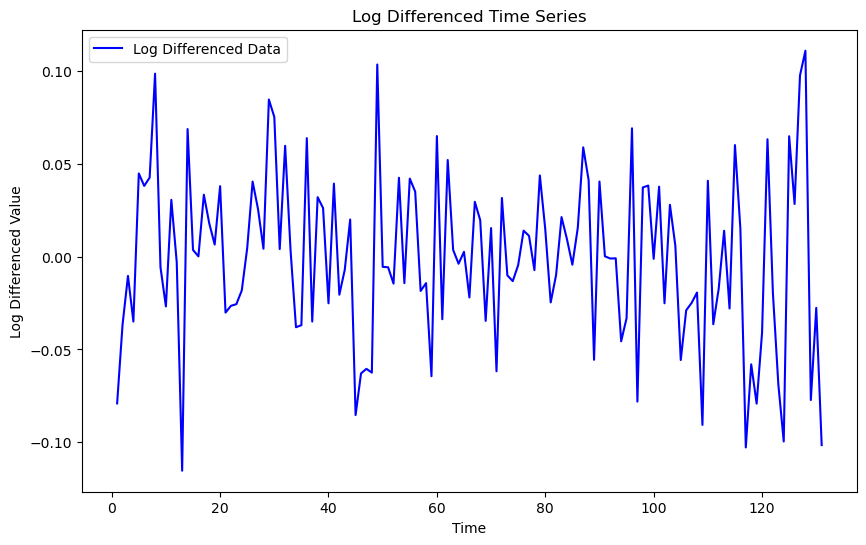

In [14]:
# 3. 로그 차분된 데이터 시각화
plt.figure(figsize=(10, 6))
plt.plot(differenced.index, differenced, label='Log Differenced Data', color='blue')
plt.title('Log Differenced Time Series')
plt.xlabel('Time')
plt.ylabel('Log Differenced Value')
plt.legend()
plt.show()

In [16]:
# ADF 검정 수행
adf_test = adfuller(differenced.dropna())

# 결과 출력
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

for key, value in adf_test[4].items():
    print(f'Critical Values {key}: {value}')

ADF Statistic: -2.133264823093477
p-value: 0.2313506721866903
Critical Values 1%: -3.4865346059036564
Critical Values 5%: -2.8861509858476264
Critical Values 10%: -2.579896092790057


<Figure size 1200x600 with 0 Axes>

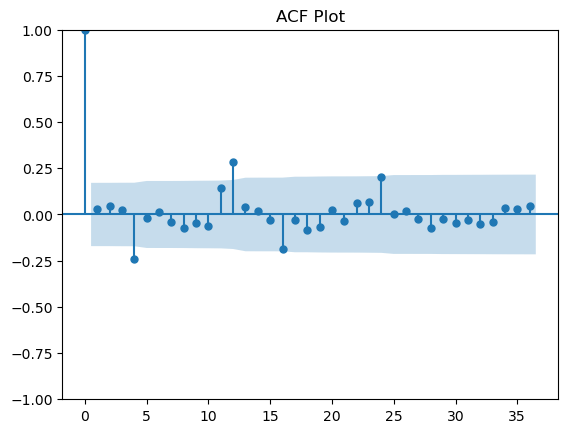

In [18]:
# ACF 플롯
plt.figure(figsize=(12, 6))
plot_acf(differenced, lags=36)
plt.title('ACF Plot')
plt.show()

<Figure size 1200x600 with 0 Axes>

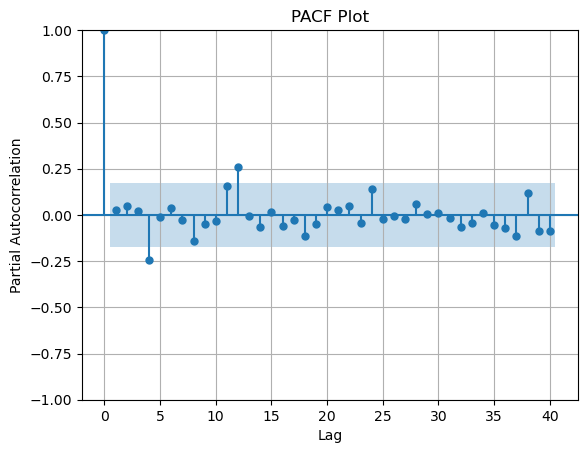

In [20]:
# PACF 플롯
plt.figure(figsize=(12, 6))
plot_pacf(differenced, lags=40)
plt.title('PACF Plot')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()

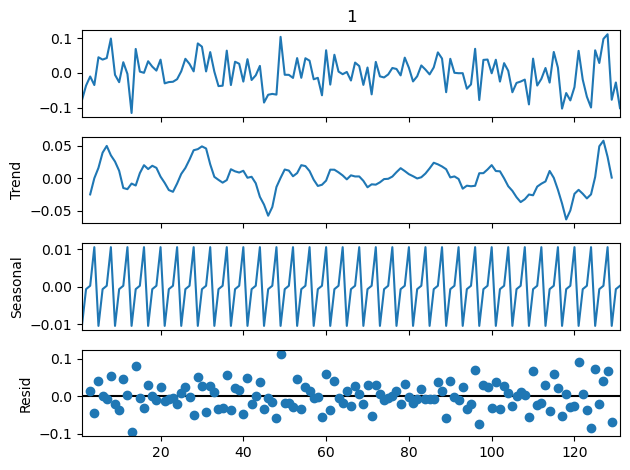

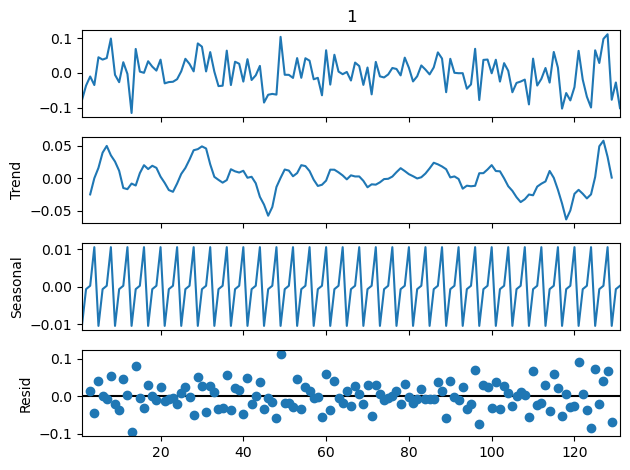

In [34]:
result = seasonal_decompose(differenced, model='additive', period=4)
result.plot()

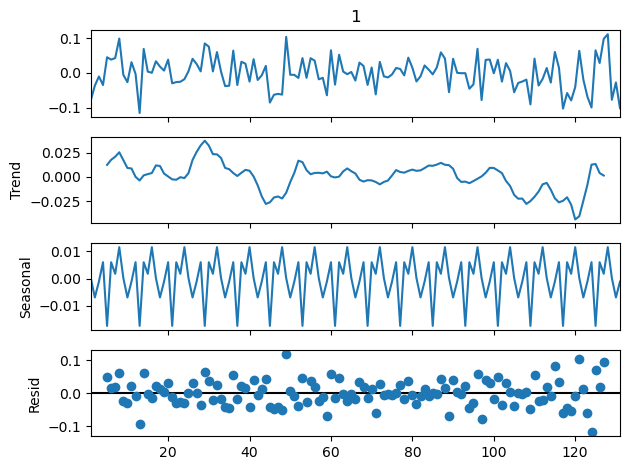

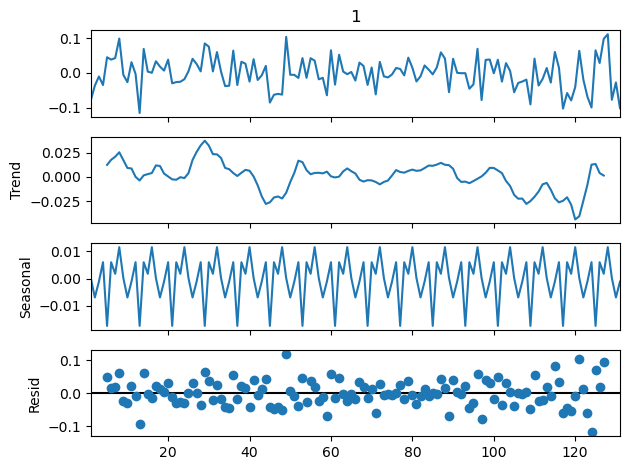

In [32]:
result2 = seasonal_decompose(differenced, model='additive', period=12)
result.plot()

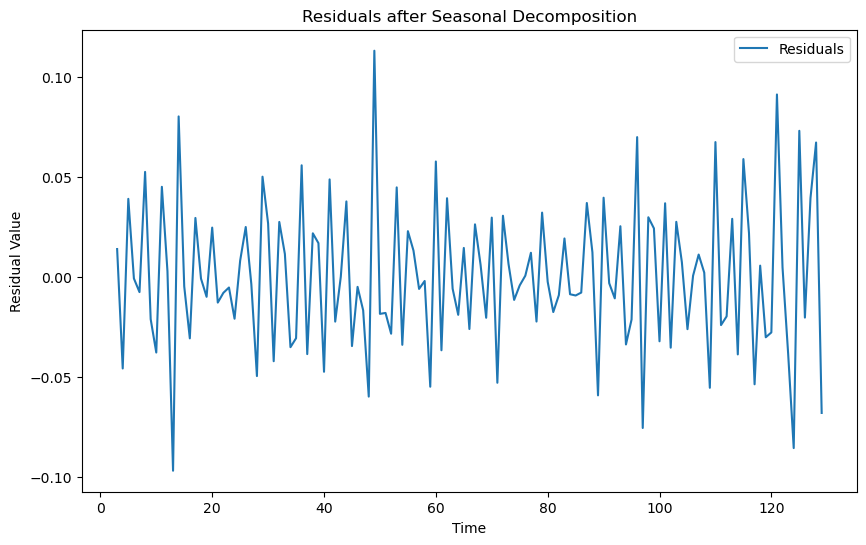

In [226]:
residuals = result.resid.dropna()  # 잔차(NA 값 제거)

# 잔차 시각화
plt.figure(figsize=(10, 6))
plt.plot(residuals, label='Residuals')
plt.title('Residuals after Seasonal Decomposition')
plt.xlabel('Time')
plt.ylabel('Residual Value')
plt.legend()
plt.show()

In [227]:
adf_result = adfuller(residuals)
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])

# 추가 출력 정보
print('Critical Values:')
for key, value in adf_result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.708275
p-value: 0.000000
Critical Values:
	1%: -3.490
	5%: -2.887
	10%: -2.581


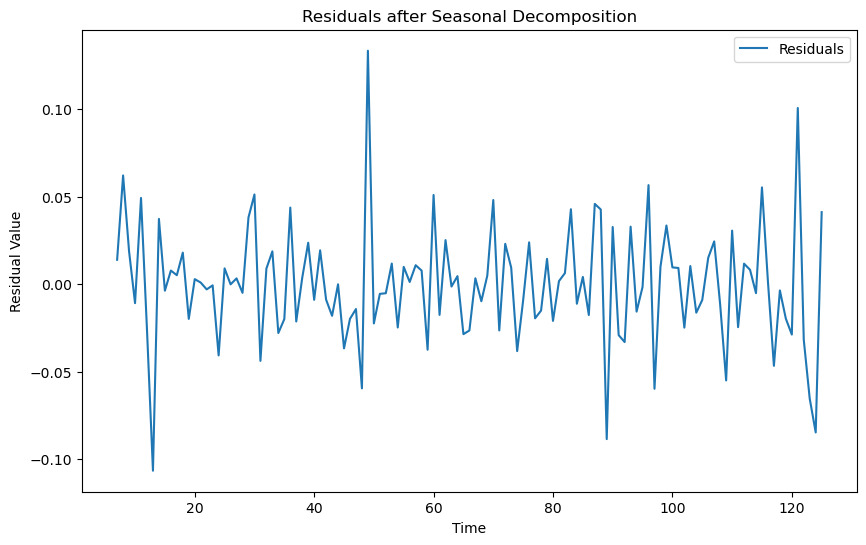

In [231]:
residuals2 = result2.resid.dropna()  # 잔차(NA 값 제거)

# 잔차 시각화
plt.figure(figsize=(10, 6))
plt.plot(residuals2, label='Residuals')
plt.title('Residuals after Seasonal Decomposition')
plt.xlabel('Time')
plt.ylabel('Residual Value')
plt.legend()
plt.show()

In [233]:
adf_result = adfuller(residuals2)
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])

# 추가 출력 정보
print('Critical Values:')
for key, value in adf_result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.084999
p-value: 0.000000
Critical Values:
	1%: -3.489
	5%: -2.887
	10%: -2.580


In [36]:
p = q = range(0, 3)
P = Q = range(0, 3)
D = 1  # 계절 차분 차수 D=1로 고정
m = 4  # 계절 주기 (사용자 설정, 예: 4)

# 가능한 모든 파라미터 조합을 생성합니다.
pdq = [(x[0], 1, x[1]) for x in itertools.product(p, q)]
seasonal_pdq = [(x[0], D, x[1], m) for x in itertools.product(P, Q)]

# 데이터가 로그 차분된 시계열 데이터라고 가정합니다.
# differenced_data = 로그 차분된 데이터

aic_results = []
best_aic = np.inf
best_order = None
best_seasonal_order = None
best_model = None

# 모든 파라미터 조합에 대해 SARIMA 모델을 피팅하고 AIC를 계산합니다.
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = SARIMAX(differenced,
                            order=param,
                            seasonal_order=param_seasonal,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            results = model.fit(disp=False)
            aic_results.append((param, param_seasonal, results.aic))
            
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = param
                best_seasonal_order = param_seasonal
                best_model = results
                
        except Exception as e:
            continue

# 최적의 모델 파라미터와 AIC를 출력합니다.
print('Best SARIMA model order {} seasonal_order {} - AIC:{}'.format(best_order, best_seasonal_order, best_aic))

# 최적 모델의 요약 출력
print(best_model.summary())

C:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\anaconda\Lib\site-packages\statsmodel

Best SARIMA model order (0, 1, 1) seasonal_order (2, 1, 2, 4) - AIC:-385.89954957286335
                                       SARIMAX Results                                        
Dep. Variable:                                      1   No. Observations:                  131
Model:             SARIMAX(0, 1, 1)x(2, 1, [1, 2], 4)   Log Likelihood                 198.950
Date:                                Tue, 20 Aug 2024   AIC                           -385.900
Time:                                        16:06:57   BIC                           -369.378
Sample:                                             0   HQIC                          -379.193
                                                - 131                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------

C:\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [38]:
# 이전에 선택된 최적의 SARIMA 모델 파라미터
order = (0, 1, 1)
seasonal_order = (2, 1, 2, 4)

# 모델 피팅
model = SARIMAX(differenced, 
                order=order, 
                seasonal_order=seasonal_order, 
                enforce_stationarity=False, 
                enforce_invertibility=False)
results = model.fit()

# 요약 통계 출력
print(results.summary())

C:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                       SARIMAX Results                                        
Dep. Variable:                                      1   No. Observations:                  131
Model:             SARIMAX(0, 1, 1)x(2, 1, [1, 2], 4)   Log Likelihood                 198.950
Date:                                Tue, 20 Aug 2024   AIC                           -385.900
Time:                                        16:22:02   BIC                           -369.378
Sample:                                             0   HQIC                          -379.193
                                                - 131                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9993      1.343     -0.744      0.457      -3.631       1.633
ar.

Forecasted Values:
 131   -0.014756
132   -0.006737
133   -0.018068
134   -0.014961
135   -0.037011
136   -0.012237
137   -0.002756
138    0.024725
139    0.034111
140   -0.039352
141   -0.021710
142   -0.048101
Name: predicted_mean, dtype: float64
Confidence Intervals:
       lower 1   upper 1
131 -0.095879  0.066368
132 -0.087880  0.074407
133 -0.099212  0.063076
134 -0.096105  0.066182
135 -0.120461  0.046440
136 -0.095700  0.071226
137 -0.086219  0.080706
138 -0.058738  0.108188
139 -0.050028  0.118250
140 -0.123500  0.044796
141 -0.105858  0.062438
142 -0.132249  0.036046


C:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


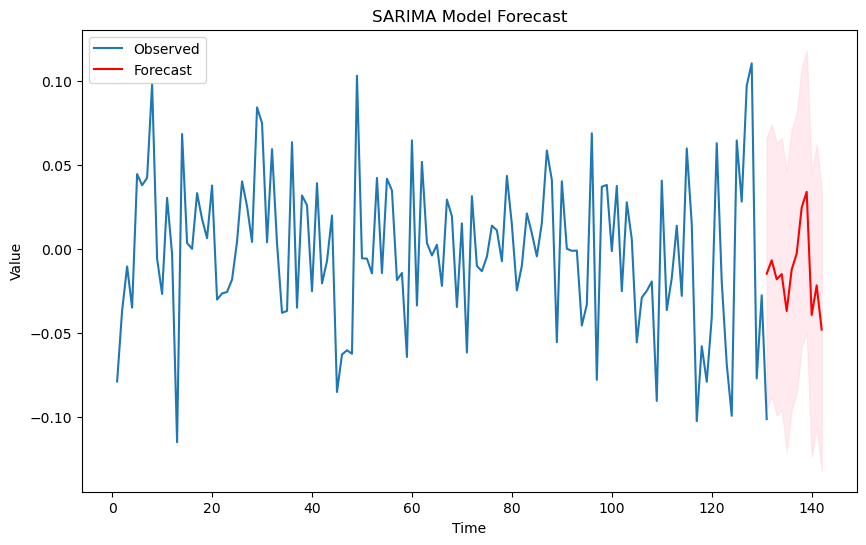

In [327]:
# 예측할 기간 설정 (예: 12개의 미래 데이터 포인트 예측)
n_periods = 12

# 예측
forecast = results.get_forecast(steps=n_periods)
forecast_index = np.arange(len(differenced), len(differenced) + n_periods)

# 예측된 값 및 신뢰 구간 추출
forecast_values = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# 결과 출력
print("Forecasted Values:\n", forecast_values)
print("Confidence Intervals:\n", forecast_conf_int)

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(differenced.index, differenced, label='Observed')
plt.plot(forecast_index, forecast_values, label='Forecast', color='red')
plt.fill_between(forecast_index, 
                 forecast_conf_int.iloc[:, 0], 
                 forecast_conf_int.iloc[:, 1], 
                 color='pink', alpha=0.3)
plt.title('SARIMA Model Forecast')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [329]:
# 실제값 (테스트 세트)
train = differenced[:-12]  # 마지막 12개월을 제외한 데이터를 훈련 데이터로 사용
test = differenced[-12:]   # 마지막 12개월을 테스트 데이터로 사용

# SARIMA 모델로 예측
model = SARIMAX(train, order=(0, 1, 1), seasonal_order=(2, 1, 2, 4))
results = model.fit()
predicted_values = results.get_forecast(steps=12).predicted_mean

# 예측 값과 실제 값 비교
comparison_df = pd.DataFrame({
    'Actual': test,
    'Predicted': predicted_values
})
# NaN 값이 포함된 행 제거
comparison_df_clean = comparison_df.dropna()

print(comparison_df_clean)


C:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


       Actual  Predicted
120 -0.040913  -0.039646
121  0.063098  -0.003970
122 -0.019528  -0.013495
123 -0.068657  -0.011434
124 -0.099522  -0.033416
125  0.064720  -0.029450
126  0.028252  -0.001173
127  0.097452  -0.008408
128  0.110719  -0.068292
129 -0.077226  -0.033194
130 -0.027637  -0.042361


C:\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [331]:
rmse = np.sqrt(mean_squared_error(comparison_df_clean['Actual'], comparison_df_clean['Predicted']))
print('RMSE:', rmse)

RMSE: 0.07823113269608267


In [333]:
mae = mean_absolute_error(comparison_df_clean['Actual'], comparison_df_clean['Predicted'])
print('MAE:', mae)

MAE: 0.06044708961746572


In [321]:
mape = np.mean(np.abs((comparison_df_clean['Actual'] - comparison_df_clean['Predicted']) / comparison_df_clean['Actual'])) * 100
print('MAPE:', mape)

MAPE: 99.35229324131245


In [335]:
p = q = range(0, 3)
P = Q = range(0, 3)
D = 1  # 계절 차분 차수 D=1로 고정
m = 12  # 계절 주기 (예: 12개월)

# 가능한 모든 파라미터 조합을 생성합니다.
pdq = [(x[0], 1, x[1]) for x in itertools.product(p, q)]
seasonal_pdq = [(x[0], D, x[1], m) for x in itertools.product(P, Q)]

# 데이터가 로그 차분된 시계열 데이터라고 가정합니다.
# differenced_data = 로그 차분된 데이터

aic_results = []
best_aic = np.inf
best_order = None
best_seasonal_order = None
best_model = None

# 모든 파라미터 조합에 대해 SARIMA 모델을 피팅하고 AIC를 계산합니다.
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = SARIMAX(differenced,
                            order=param,
                            seasonal_order=param_seasonal,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            results = model.fit(disp=False)
            aic_results.append((param, param_seasonal, results.aic))
            
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = param
                best_seasonal_order = param_seasonal
                best_model = results
                
        except Exception as e:
            continue

# 최적의 모델 파라미터와 AIC를 출력합니다.
print('Best SARIMA model order {} seasonal_order {} - AIC:{}'.format(best_order, best_seasonal_order, best_aic))

# 최적 모델의 요약 출력
print(best_model.summary())

C:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\anaconda\Lib\site-packages\statsmodel

Best SARIMA model order (1, 1, 1) seasonal_order (0, 1, 0, 12) - AIC:-357.246381935779
                                      SARIMAX Results                                      
Dep. Variable:                                   1   No. Observations:                  131
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 12)   Log Likelihood                 181.623
Date:                             Mon, 19 Aug 2024   AIC                           -357.246
Time:                                     17:01:52   BIC                           -348.986
Sample:                                          0   HQIC                          -353.893
                                             - 131                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.15

C:\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [40]:
# 이전에 선택된 최적의 SARIMA 모델 파라미터
order = (1, 1, 1)
seasonal_order = (0, 1, 0, 12)

# 모델 피팅
model2 = SARIMAX(differenced, 
                order=order, 
                seasonal_order=seasonal_order, 
                enforce_stationarity=False, 
                enforce_invertibility=False)
results2 = model2.fit()

# 요약 통계 출력
print(results2.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   1   No. Observations:                  131
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 12)   Log Likelihood                 181.623
Date:                             Tue, 20 Aug 2024   AIC                           -357.246
Time:                                     16:24:47   BIC                           -348.986
Sample:                                          0   HQIC                          -353.893
                                             - 131                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1562      0.091     -1.725      0.085      -0.334       0.021
ma.L1         -1.0000    11

C:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [339]:
# 실제값 (테스트 세트)
train = differenced[:-12]  # 마지막 12개월을 제외한 데이터를 훈련 데이터로 사용
test = differenced[-12:]   # 마지막 12개월을 테스트 데이터로 사용

# SARIMA 모델로 예측
model2 = SARIMAX(train, order=(1, 1, 1), seasonal_order=(0, 1, 0, 12))
results2 = model2.fit()
predicted_values = results2.get_forecast(steps=12).predicted_mean

# 예측 값과 실제 값 비교
comparison_df = pd.DataFrame({
    'Actual': test,
    'Predicted': predicted_values
})
# NaN 값이 포함된 행 제거
comparison_df_clean = comparison_df.dropna()

print(comparison_df_clean)


       Actual  Predicted
120 -0.040913  -0.120211
121  0.063098   0.017471
122 -0.019528  -0.062220
123 -0.068657  -0.042132
124 -0.099522  -0.011319
125  0.064720  -0.053017
126  0.028252   0.034866
127  0.097452  -0.010114
128  0.110719  -0.127803
129 -0.077226  -0.083093
130 -0.027637  -0.104238


C:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [343]:
rmse = np.sqrt(mean_squared_error(comparison_df_clean['Actual'], comparison_df_clean['Predicted']))
print('RMSE:', rmse)

RMSE: 0.09860271524245476


In [345]:
mae = mean_absolute_error(comparison_df_clean['Actual'], comparison_df_clean['Predicted'])
print('MAE:', mae)

MAE: 0.07593205813659552


In [347]:
mape = np.mean(np.abs((comparison_df_clean['Actual'] - comparison_df_clean['Predicted']) / comparison_df_clean['Actual'])) * 100
print('MAPE:', mape)

MAPE: 129.81079245846382


Forecasted Values:
 119   -0.032976
120   -0.120211
121    0.017471
122   -0.062220
123   -0.042132
124   -0.011319
125   -0.053017
126    0.034866
127   -0.010114
128   -0.127803
129   -0.083093
130   -0.104238
Name: predicted_mean, dtype: float64
Confidence Intervals:
       lower 1   upper 1
119 -0.126715  0.060763
120 -0.214662 -0.025761
121 -0.081618  0.116560
122 -0.162235  0.037796
123 -0.144136  0.059872
124 -0.114812  0.092174
125 -0.158151  0.052117
126 -0.071815  0.141547
127 -0.118346  0.098119
128 -0.237555 -0.018052
129 -0.194347  0.028161
130 -0.216973  0.008497


C:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


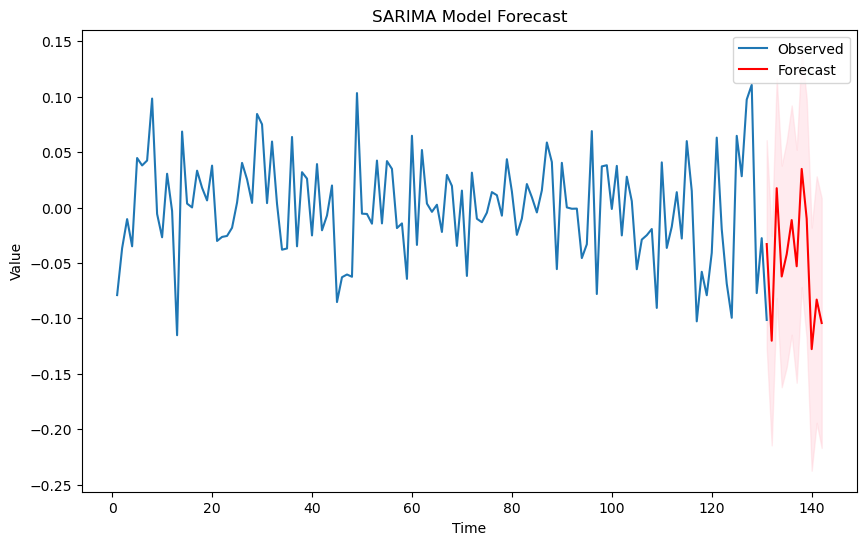

In [341]:
# 예측할 기간 설정 (예: 12개의 미래 데이터 포인트 예측)
n_periods = 12

# 예측
forecast = results2.get_forecast(steps=n_periods)
forecast_index = np.arange(len(differenced), len(differenced) + n_periods)

# 예측된 값 및 신뢰 구간 추출
forecast_values = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# 결과 출력
print("Forecasted Values:\n", forecast_values)
print("Confidence Intervals:\n", forecast_conf_int)

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(differenced.index, differenced, label='Observed')
plt.plot(forecast_index, forecast_values, label='Forecast', color='red')
plt.fill_between(forecast_index, 
                 forecast_conf_int.iloc[:, 0], 
                 forecast_conf_int.iloc[:, 1], 
                 color='pink', alpha=0.3)
plt.title('SARIMA Model Forecast')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [269]:
# 로그 차분된 예측 값을 적분하여 로그 스케일로 변환
forecast_log_values = forecast_values.cumsum() + log_cow_df1.iloc[-1]

# 로그를 반전하여 원래 스케일로 변환
forecast_original_scale = np.exp(forecast_log_values)

# 원래 스케일로 변환된 예측 값 출력
print("Forecasted Values in Original Scale:\n", forecast_original_scale)

Forecasted Values in Original Scale:
 131    12517.274992
132    13312.166872
133    13042.609221
134    12164.748008
135    11001.283936
136    11724.981338
137    12048.788360
138    13268.672493
139    14807.225691
140    13692.922234
141    13306.226657
142    12010.209836
Name: predicted_mean, dtype: float64
